# TensorFlow Implementaton of Single Antigen NDE Fitting
This is an example python script to illustrate fitting an ordinary regression (iid noise) model for a single antigen using the NDE approximated likelihood model

## Step 1: Read in summarised TRaC data with matched covariates and build as TensorFlow constants 

- Age restricted to 1-50 y/o (to limit impact of maternal anti-bodies and limit look-back time)

- Sites snapped to land-sea mask boundary and standardised covariates extracted

- Area including Port-au-Prince and surrounds excluded (to limit impact of migration) 

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.io import mmread
import osgeo.gdal as gdal
import os
import matplotlib.pyplot as plt
import pickle

# Start a tensorflow session
sess = tf.Session(config = tf.ConfigProto())
sess.run(tf.global_variables_initializer())

# Import the trac data
tracdata = pd.read_csv('../trac_data/summary_TRaC_data_with_covariates.csv')
tracdata[tracdata.Age < 51]

# Village positions
village_lats = tracdata.groupby(['Cluster_Num'])['Latitude'].unique().values
village_longs = tracdata.groupby(['Cluster_Num'])['Longitude'].unique().values

# Number of villages
Nvillages = tracdata.Cluster_Num.unique().size

# Extract the titres and ages for all individuals, grouped by village
titres = tf.constant(tracdata.MSP.values, dtype='float32')
ages = tf.constant(tracdata.Age.values, dtype='float32')
cluster_assignments = tf.constant(tracdata.Cluster_Num.values, dtype='int32')
init_latent_ys = tracdata.MSP.values
init_latent_ys[init_latent_ys<1] = 1
init_latent_ys = np.log(init_latent_ys)

# Number of individuals
Nindividuals = len(tracdata.Age.values)

# Extract the mean covariates in each cell
covariates = tracdata.groupby(['Cluster_Num'])['covariate_accessibility','covariate_AI','covariate_distTowater','covariate_elevation','covariate_forest','covariate_grass','covariate_urbanbarren','covariate_woodysavanna','covariate_OSM','covariate_PET','covariate_slope','covariate_TWI'].mean().values
covariates = tf.constant(covariates, dtype='float32')

# Number of covariates
Ncovariates = covariates.shape[1]

## Step 2: Read in weights from fitted NDE to set up approximate likelihood computation 

In [7]:
# Load in the batch normalizations for re-scaling inputs to the neural likelihood
f = open('simulations/simulations/model_2/batch_normalizations.pkl', 'rb')
xs_mean, xs_std, ps_mean, ps_std = pickle.load(f)
f.close()

# Data = individual titres re-scaled by batch norms for input to the neural likelihood
data_individual = (tf.expand_dims(titres,1)-xs_mean)/ xs_std

# Set-up for the neural density estimator:
# read in weights and biases, set the architecture (to same as the trained NDE)

# Load in the network weights and biases
f = open('simulations/simulations/model_2/network_weights.pkl', 'rb')
network_weights = pickle.load(f)
f.close()
f = open('simulations/simulations/model_2/network_biases.pkl', 'rb')
network_biases = pickle.load(f)
f.close()

# Declare weights and biases as tf.constants
weights = [tf.constant(network_weights[0], dtype='float32'), tf.constant(network_weights[1], dtype='float32'), tf.constant(network_weights[2], dtype='float32'), tf.constant(network_weights[3], dtype='float32'), tf.constant(network_weights[4], dtype='float32'), tf.constant(network_weights[5], dtype='float32'), tf.constant(network_weights[6], dtype='float32')]
biases = [tf.constant(network_biases[0], dtype='float32'), tf.constant(network_biases[1], dtype='float32'),  tf.constant(network_biases[2], dtype='float32'), tf.constant(network_biases[3], dtype='float32'), tf.constant(network_biases[4], dtype='float32'), tf.constant(network_biases[5], dtype='float32'),  tf.constant(network_biases[6], dtype='float32')]

# (Global) set-up parameters for the NDE
n_antibodies = 1 # number of antibodies
n_parameters = 10 + 1 # serology + log_eir
D = n_antibodies # size of data (number of antibodies)
P = n_parameters + 1 # number of parameters (num serology parameters + EIR + age)
M = 3 # number of Gaussian components
N = int((D + D * (D + 1) / 2 + 1)*M)
n_hidden = [27, 27, 27, 27, 27, 27, 27]
activations = [tf.tanh, tf.tanh, tf.tanh, tf.tanh, tf.tanh, tf.tanh, tf.tanh]

# Functions for mapping the neural network output to the mixture model components

# Build lower triangular matrices (parameterizing the covariances) from network output (also calculate determinant)
def lower_triangular_matrix(σ):
    Σ = []
    det = []
    start = 0
    end = 1
    for i in range(D):
        exp_val = tf.exp(σ[:, :, end-1])
        det.append(exp_val)
        if i > 0:
            Σ.append(tf.pad(tf.concat([σ[:, :, start:end-1], tf.expand_dims(exp_val, -1)], -1), [[0, 0], [0, 0], [0, D-i-1]]))
        else:
            Σ.append(tf.pad(tf.expand_dims(exp_val, -1), [[0, 0], [0, 0], [0, D-i-1]]))
        start = end
        end += i + 2
    Σ = tf.transpose(tf.stack(Σ), (1, 2, 0, 3))
    det = tf.reduce_prod(tf.stack(det), 0)
    return Σ, det

# Split network output into component means, covariances and weights (also returns determinant of covariance)
def mapping(output_layer, M, D):
    μ, Σ, α = tf.split(output_layer, [M * D, M * D * (D + 1) // 2, M], 1)
    μ = tf.reshape(μ, (-1, M, D))
    Σ, det = lower_triangular_matrix(tf.reshape(Σ, (-1, M, D * (D + 1) // 2)))
    α = tf.nn.softmax(α)
    return μ, Σ, α, det

## Step 3: Set up priors for the log EIR and serology parameters

In [8]:
# Set-up prior for the log-field (here: iid noise)
log_field = tf.Variable(np.zeros(Nvillages), dtype='float32')
prior_log_field = tfp.distributions.Normal(loc = 0.0, scale = 1.0)

# Slopes and intercept for linear predictor part of the model
slopes = tf.Variable(np.zeros(Ncovariates), dtype='float32')
prior_slopes = tfp.distributions.Normal(loc = 0.0, scale = 1.0)
intercept = tf.Variable(0.0, dtype='float32')
prior_intercept = tfp.distributions.Normal(loc = -3.0, scale = 1.0)

noise_prior_mean =  tfp.distributions.Normal(loc = 5.0 , scale = 5.0)
noise_prior_logsd =  tfp.distributions.Normal(loc = tf.constant(np.log(4.0), dtype='float32') , scale = 1.0)
noise_mean = tf.Variable(0.0, dtype='float32')
noise_logsd = tf.Variable(1.0, dtype='float32')

loghet = tf.Variable(np.zeros(1), dtype='float32')
loghet_prior = tfp.distributions.Normal(loc = tf.constant(np.log(0.75), dtype='float32'), scale = 0.001)

# Serology hyper-parameters
serology_lower = tf.constant(np.array([
                          0, # fzero
                          0, # gzero
                          5, # azero
                          np.log(0.05), # logHetBoosting
                          np.log(10), # logBaselineBoostingFactor
                          np.log(10), # logBaselineBoostingThreshold
                          np.log(0.05), # logAttenuationFactor
                          2,# NAdultAntibodies
                          np.log(0.01), # logRhoChild
                          np.log(0.01) # logRhoAdultExtra
                          ]), dtype='float32')

serology_upper = tf.constant(np.array([
                          1, # fzero
                          1, # gzero
                          35, # azero
                          np.log(4), # logHetBoosting
                          np.log(30000), # logBaselineBoostingFactor
                          np.log(10000), # logBaselineBoostingThreshold
                          np.log(4), # logAttenuationFactor
                          20,# NAdultAntibodies
                          np.log(10), # logRhoChild
                          np.log(20) # logRhoAdultExtra
                          ]), dtype='float32')

prior_normal = tf.distributions.Normal(loc=0.0,scale=1.0)
serology_unbounded = tf.Variable(np.zeros(10), dtype='float32')
serology = tf.distributions.Normal(loc=0.0,scale=1.0).cdf(serology_unbounded)*(serology_upper-serology_lower)+serology_lower

## Step 4: Construct log posterior probability in tensorflow

In [9]:
# Linear predictor model for EIR: GP + C\beta + \beta_0
linear_predictor = log_field + intercept + tf.squeeze(tf.matmul(covariates,tf.expand_dims(slopes,1)))

linear_predictor_ind = tf.gather(linear_predictor, cluster_assignments-1)
ind_logeir_offset = tf.Variable(np.zeros(Nindividuals), dtype='float32')

soft_ind_logeir = -1.151293 + 6.907755*(tf.math.sigmoid((linear_predictor_ind+ind_logeir_offset - -1.15)/(6.907755/5))-0.5)

# Set up the parameters vector: list of (lambda_EIR, serology_parameters, age) for each individual
theta = (tf.concat([tf.expand_dims(soft_ind_logeir,1), # log EIR at the individuals locations
                                tf.transpose(tf.tile(tf.reshape(serology, [-1,1]), [1,Nindividuals])), # Shared serology parameters for all individuals
                                tf.transpose(tf.tile(tf.expand_dims(ages,0), [1,1]))], axis=1) - ps_mean)/ ps_std # Ages, and then shift and re-scale everything according to the batch normalization for the neural likelihood

# Set up the NDE likelihood
# Build the layers of the network
# First layer (input) is just the parameters
layers = [theta] 
# Now loop through the hidden layers
for i in range(len(n_hidden)):
    if i < len(n_hidden) - 1:
        layers.append(activations[i](tf.add(tf.matmul(layers[i], weights[i]), biases[i])))
    else:
        layers.append(tf.add(tf.matmul(layers[i], weights[i]), biases[i]))
# Map the output layer to mixture model parameters
μ, Σ, α, det = mapping(layers[-1], M, D)

# Compute the log likelihood
latent_log_y = tf.Variable(init_latent_ys, dtype='float32')
log_prob_latent_y = tf.reduce_sum(tf.log(tf.reduce_sum(tf.exp(-0.5*tf.reduce_sum(tf.square(tf.einsum("ijlk,ijk->ijl", Σ, tf.subtract(tf.expand_dims((tf.expand_dims(latent_log_y,1)-xs_mean)/ xs_std, 1), μ))), 2) + tf.log(α) + tf.log(det) - D*np.log(2. * np.pi) / 2.), 1) + 1e-37))
log_likelihood = tf.reduce_sum(tfp.distributions.Normal(loc = (tf.exp(latent_log_y)+noise_mean), scale = tf.exp(noise_logsd)).log_prob(titres))
                                                                                  
# Log prior over hyper-parameters and log-field (GP)
log_prior = tf.reduce_sum(prior_log_field.log_prob(log_field)) \
+ tf.reduce_sum(prior_slopes.log_prob(slopes)) \
+ prior_intercept.log_prob(intercept) \
+ tf.reduce_sum(prior_normal.log_prob(serology_unbounded)) \
+ loghet_prior.log_prob(loghet) \
+ tf.reduce_sum(tfp.distributions.Normal(loc = -tf.exp(loghet*2.0)/2.0, scale = tf.exp(loghet)).log_prob(ind_logeir_offset)) \
+ noise_prior_mean.log_prob(noise_mean) + noise_prior_logsd.log_prob(noise_logsd)

# Negative log posterior
negative_log_posterior_prob = -(log_likelihood + log_prior + log_prob_latent_y)

### Step 5: Construct Posterior and Single Parameter Std Devs

[19690.629]


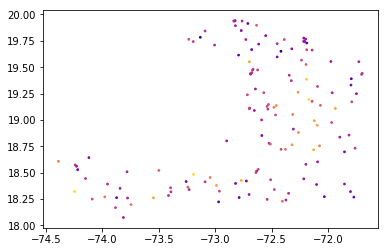

Sero Param Name : Posterior Mean : Posterior Std Dev
fzero 0.9986277 0.010415042268249209
gzero 0.013523082 0.021701691778673787
azero 34.423607 0.6392089378412065
HetBoosting 3.0464935 0.010745461098190806
BaselineBoostingFactor 39.075115 0.4652470270495637
BaselineBoostingThreshold 9838.358 351.70364998325425
logAttenuationFactor 0.17579587 0.01458965451960432
NpastAdultAntibodies 16.129223 0.18446889875087144
RhoChild 2.9241414 0.06496558208744904
RhoAdult 14.904194 0.3775650045037493
Covariate Name: Posterior Mean : Posterior Std Dev
accessibility_to_cities_2015 0.06616862 0.005290711967770591
aridity_index 0.0035125175 0.0055822250834234345
DistToWater 0.046583835 0.014378499889573229
Elevation -0.05843636 0.005077857682170307
Landcover_forest 0.02398127 0.03322751946886331
Landcover_grass_savanna 0.07144799 0.03689951563025967
Landcover_urban_barren -0.0036599697 0.016906093694097662
Landcover_woodysavanna 0.030076975 0.019999542007919736
openStreetMapv32 0.06184886 0.00670679107

In [10]:
admsero_u = tf.train.AdagradOptimizer(learning_rate=0.1).minimize(negative_log_posterior_prob)
sess.run(tf.global_variables_initializer())
for i in range(0,10000): 
    sess.run(admsero_u)
    if ((i % 1000)==0):
        print(sess.run(tf.gradients(negative_log_posterior_prob,serology)))
        print(sess.run(negative_log_posterior_prob))
    
hessian_serology = sess.run(tf.hessians(negative_log_posterior_prob,serology))[0]
hessian_log_field = sess.run(tf.hessians(negative_log_posterior_prob,log_field))[0]
hessian_slopes = sess.run(tf.hessians(negative_log_posterior_prob,slopes))[0]

plt.scatter(village_longs, village_lats, c=sess.run(linear_predictor), s = 3, cmap="plasma") # check image coordinate transforms by comparing raster plot against observation locations 
plt.show()

print("Sero Param Name : Posterior Mean : Posterior Std Dev")
print("fzero",sess.run(serology)[0],np.sqrt(1.0/hessian_serology[0,0]))
print("gzero",sess.run(serology)[1],np.sqrt(1.0/hessian_serology[1,1]))
print("azero",sess.run(serology)[2],np.sqrt(1.0/hessian_serology[2,2]))
print("HetBoosting",np.exp(sess.run(serology)[3]),np.exp(sess.run(serology)[3])*np.sqrt(1.0/hessian_serology[3,3]))
print("BaselineBoostingFactor",np.exp(sess.run(serology)[4]),np.exp(sess.run(serology)[4])*np.sqrt(1.0/hessian_serology[4,4]))
print("BaselineBoostingThreshold",np.exp(sess.run(serology)[5]),np.exp(sess.run(serology)[5])*np.sqrt(1.0/hessian_serology[5,5]))
print("logAttenuationFactor",np.exp(sess.run(serology)[6]),np.exp(sess.run(serology)[6])*np.sqrt(1.0/hessian_serology[6,6]))
print("NpastAdultAntibodies",sess.run(serology)[7],np.sqrt(1.0/hessian_serology[7,7]))
print("RhoChild",np.exp(sess.run(serology)[8]),np.exp(sess.run(serology)[8])*np.sqrt(1.0/hessian_serology[8,8]))
print("RhoAdult",np.exp(sess.run(serology)[9])+np.exp(sess.run(serology)[8]),np.sqrt((np.exp(sess.run(serology)[8])*np.sqrt(1.0/hessian_serology[8,8]))**2.0+(np.exp(sess.run(serology)[9])*np.sqrt(1.0/hessian_serology[9,9]))**2.0))

print("Covariate Name: Posterior Mean : Posterior Std Dev")
print("accessibility_to_cities_2015",sess.run(slopes)[0],np.sqrt(1.0/hessian_slopes[0,0]))
print("aridity_index",sess.run(slopes)[1],np.sqrt(1.0/hessian_slopes[1,1]))
print("DistToWater",sess.run(slopes)[2],np.sqrt(1.0/hessian_slopes[2,2]))
print("Elevation",sess.run(slopes)[3],np.sqrt(1.0/hessian_slopes[3,3]))
print("Landcover_forest",sess.run(slopes)[4],np.sqrt(1.0/hessian_slopes[4,4]))
print("Landcover_grass_savanna",sess.run(slopes)[5],np.sqrt(1.0/hessian_slopes[5,5]))
print("Landcover_urban_barren",sess.run(slopes)[6],np.sqrt(1.0/hessian_slopes[6,6]))
print("Landcover_woodysavanna",sess.run(slopes)[7],np.sqrt(1.0/hessian_slopes[7,7]))
print("openStreetMapv32",sess.run(slopes)[8],np.sqrt(1.0/hessian_slopes[8,8]))
print("PotentialEvapoTranspiration",sess.run(slopes)[9],np.sqrt(1.0/hessian_slopes[9,9]))
print("Slope",sess.run(slopes)[10],np.sqrt(1.0/hessian_slopes[10,10]))
print("TopologicalWetnessIndex",sess.run(slopes)[11],np.sqrt(1.0/hessian_slopes[11,11]))

print("Heterogeneity: ",np.exp(sess.run(loghet)))
print("Noise Mean: ",np.exp(sess.run(noise_mean)))
print("Noise Std Dev: ",np.exp(sess.run(noise_logsd)))


In [22]:
admsero_u = tf.train.AdagradOptimizer(learning_rate=8,).minimize(negative_log_posterior_prob)
sess.run(tf.global_variables_initializer())
for i in range(0,10000): 
    sess.run(admsero_u)
    if ((i % 1000)==0):
        print(sess.run(tf.gradients(negative_log_posterior_prob,serology_unbounded)))
        print(sess.run(negative_log_posterior_prob))

[array([-7.9999986,  7.9994435,  7.9999866,  7.9999986, -7.999999 ,
        7.999999 , -7.999999 ,  7.999999 , -8.       , -8.       ],
      dtype=float32)]
[5.904526e+22]
[array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)]
[nan]


KeyboardInterrupt: 